# Exam simulation
## Starting time: 15.00
## End before: 20.00
## Actual ending time: 

## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
# If you didn't download it yet, please get the relevant file now!
#!curl -L -O https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   123  100   123    0     0    481      0 --:--:-- --:--:-- --:--:--   482
100    17  100    17    0     0     21      0 --:--:-- --:--:-- --:--:--    21
100 31.6M  100 31.6M    0     0   948k      0  0:00:34  0:00:34 --:--:--  960k1k    0     0   901k      0  0:00:35  0:00:07  0:00:28  956k3M    0     0   939k      0  0:00:34  0:00:19  0:00:15  959k


1. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger than 10k.

In [86]:
# Import needed packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
# Let's have a look at the data_000637.txt file
#! cat data_000637.txt #they're comma separated values, hence I'll upload it as read_csv

# Let's make the DataFrame
data = pd.read_csv('data_000637.txt') #In general I could've used pandas.read_table

#Let's see the dimension of the DataFrame
print(data, '\n') # It says there are 1 310 720 rows
print("Number of rows:", len(data))# this is just another way to do the same 
# Choose N to be smaller than, or equal to the maximum number of rows and larger than 10k. 

N = int(len(data)/2)

# Read N rows of the given file. 

df = data.head(N) # This makes a copy so data is still unchanged, while df is shorter
print(df)


         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0           1     0          123  3869200167        2374        26
1           1     0          124  3869200167        2374        27
2           1     0           63  3869200167        2553        28
3           1     0           64  3869200167        2558        19
4           1     0           64  3869200167        2760        25
...       ...   ...          ...         ...         ...       ...
1310715     1     0           62  3869211171         762        14
1310716     1     1            4  3869211171         763        11
1310717     1     0           64  3869211171         764         0
1310718     1     0          139  3869211171         769         0
1310719     1     0           61  3869211171         762        18

[1310720 rows x 6 columns] 

Number of rows: 1310720
        HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0          1     0          123  3869200167        2374        26
1         

2. Find out the number of BX in a ORBIT (the value 'x').

Number of BX in one ORBIT: 3563


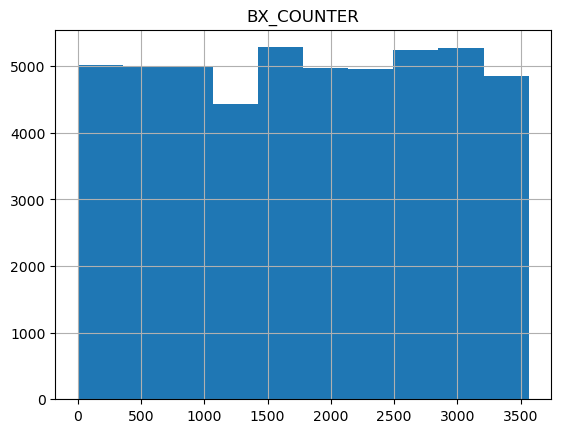

In [28]:
# In a TDC there are 25/30 ns --> like "seconds" 
# In a BX_COUNTER there are 25 ns --> like "minutes" --> 30 TDC
# In a ORBIT_CNT updated every x BX_COUNTER counts --> like "hours" 

# To have an idea of how many BX_COUNTERS there are to make an ORBIT_CNT we can see what is the maximum and minimum value they assume. 
# Indeed in an hour there are 60 minutes because after that the clock starts counting minutes from the beginning. 

# NOTICE: in our data we have not gathered data at each BX, so the "count of minutes" is not continuos. 
# However the data are gonna be uniformly (random) distributed among the min and max values.

df.hist('BX_COUNTER')
x = np.max(df['BX_COUNTER']) - np.min(df['BX_COUNTER'])

print("Number of BX in one ORBIT:", x)


3. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [ ]:
# Let's first have the rough estimate. I'm reading half of the lines present in the dataset. 
last = df.tail(1) # this way I visualize the last row (larger measured time for half dataset)

def ns_time(orb,bx,tdc, x):
    ns = orb*x*25 + bx*25 + tdc*(25/30)
    return float(ns.iloc[0])

def time(ns): 
    sec_tot = ns * 10**(-9)
    mins_tot = sec_tot // 60
    hours_tot = mins_tot // 60

    sec_rem = sec_tot - mins_tot*60 
    mins_rem = mins_tot - hours_tot*60
    
    return hours_tot, mins_rem, sec_rem
    
ns_half = 2*ns_time(last['ORBIT_CNT'], last['BX_COUNTER'], last['TDC_MEAS'], x)

print("estimated measuring time in ns:", ns_half)
print("estimated measuring time in hours, minutes, seconds:", time(ns_half))
print("estimated measuring time in days:", time(ns_half)[0]//24)

#Let's do the computation precisely using the whole dataset
true_last = data.tail(1)
ns_true = ns_time(true_last['ORBIT_CNT'], true_last['BX_COUNTER'], true_last['TDC_MEAS'], x)

print("true measuring time in ns:", ns_true)
print("true measuring time in hours, minutes, seconds:", time(ns_true))
print("true measuring in days:", time(ns_true)[0]//24)


### NOTICE: 
The fact that the true time is half the estimated one could be because the frequency of measurements has changed over time. 
There's not a huge variation of the average. However, due to the large dataset, small errors can become very large. 

In [94]:
df = df.copy() # This avoids getting the warning message that otherwise occurs when trying to modify a dataframe obatined slicing another one
df['time_ns'] = df['ORBIT_CNT'] * x * 25 + df['BX_COUNTER'] * 25 + df['TDC_MEAS'] * (25 / 30)
df['time_diff_ns'] = df['time_ns'].diff()  # Compute time difference between consecutive rows
print(df[['time_ns', 'time_diff_ns']].describe())  # Look at stats of time differences

half_point = len(df) // 2
early_avg = df.iloc[:half_point]['time_diff_ns'].mean()
late_avg = df.iloc[half_point:]['time_diff_ns'].mean()
print("Average time difference - Early:", early_avg, "Late:", late_avg)

            time_ns   time_diff_ns
count  6.553600e+05  655359.000000
mean   3.446493e+14     883.681293
std    1.706589e+08    4055.431233
min    3.446490e+14   -2483.312500
25%    3.446492e+14     -28.312500
50%    3.446493e+14      57.500000
75%    3.446494e+14     194.125000
max    3.446496e+14  199651.625000
Average time difference - Early: 891.4339973342815 Late: 875.9286117553711


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [96]:
# This was done in the previous cell

df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns,time_diff_ns
0,1,0,123,3869200167,2374,26,3.446490e+14,NaN
1,1,0,124,3869200167,2374,27,3.446490e+14,0.8125
2,1,0,63,3869200167,2553,28,3.446490e+14,4475.8125
3,1,0,64,3869200167,2558,19,3.446490e+14,117.5000
4,1,0,64,3869200167,2760,25,3.446490e+14,5055.0000
...,...,...,...,...,...,...,...,...
655355,1,0,36,3869206669,880,0,3.446496e+14,52.5000
655356,1,0,40,3869206669,878,23,3.446496e+14,-30.8125
655357,1,0,124,3869206669,881,2,3.446496e+14,57.5000
655358,1,0,60,3869206669,875,5,3.446496e+14,-147.5000


5. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [99]:
df['HEAD'] = np.random.choice([0,1], len(df))
df

# NOTICE: if it wasn't that previously I defined df = df.copy(), now I'd have to use: 
# df.loc[:,'HEAD'] = rnd.choice([0,1], size = len(df))

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns,time_diff_ns
0,0,0,123,3869200167,2374,26,3.446490e+14,NaN
1,1,0,124,3869200167,2374,27,3.446490e+14,0.8125
2,0,0,63,3869200167,2553,28,3.446490e+14,4475.8125
3,0,0,64,3869200167,2558,19,3.446490e+14,117.5000
4,0,0,64,3869200167,2760,25,3.446490e+14,5055.0000
...,...,...,...,...,...,...,...,...
655355,1,0,36,3869206669,880,0,3.446496e+14,52.5000
655356,0,0,40,3869206669,878,23,3.446496e+14,-30.8125
655357,0,0,124,3869206669,881,2,3.446496e+14,57.5000
655358,0,0,60,3869206669,875,5,3.446496e+14,-147.5000


6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [101]:
filt_df = df[df['HEAD'] == 1]

filt_df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns,time_diff_ns
1,1,0,124,3869200167,2374,27,3.446490e+14,0.8125
10,1,1,7,3869200167,2785,4,3.446490e+14,-77.5000
11,1,0,64,3869200167,2786,19,3.446490e+14,37.5000
15,1,1,139,3869200167,2797,0,3.446490e+14,197.5000
17,1,0,63,3869200167,2790,10,3.446490e+14,71.6250
...,...,...,...,...,...,...,...,...
655348,1,0,31,3869206669,848,18,3.446496e+14,-48.3125
655349,1,0,27,3869206669,843,8,3.446496e+14,-133.3125
655352,1,0,32,3869206669,872,0,3.446496e+14,7.5000
655355,1,0,36,3869206669,880,0,3.446496e+14,52.5000


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel.

FPGA  TDC_CHANNEL
0     1                612
      2                777
      3                763
      4               1168
      5                725
                     ...  
1     129               14
      130               17
      137               15
      138               15
      139            16286
Length: 256, dtype: int64

     FPGA  TDC_CHANNEL  Counts
0       0            1     612
1       0            2     777
2       0            3     763
3       0            4    1168
4       0            5     725
..    ...          ...     ...
251     1          129      14
252     1          130      17
253     1          137      15
254     1          138      15
255     1          139   16286

[256 rows x 3 columns]


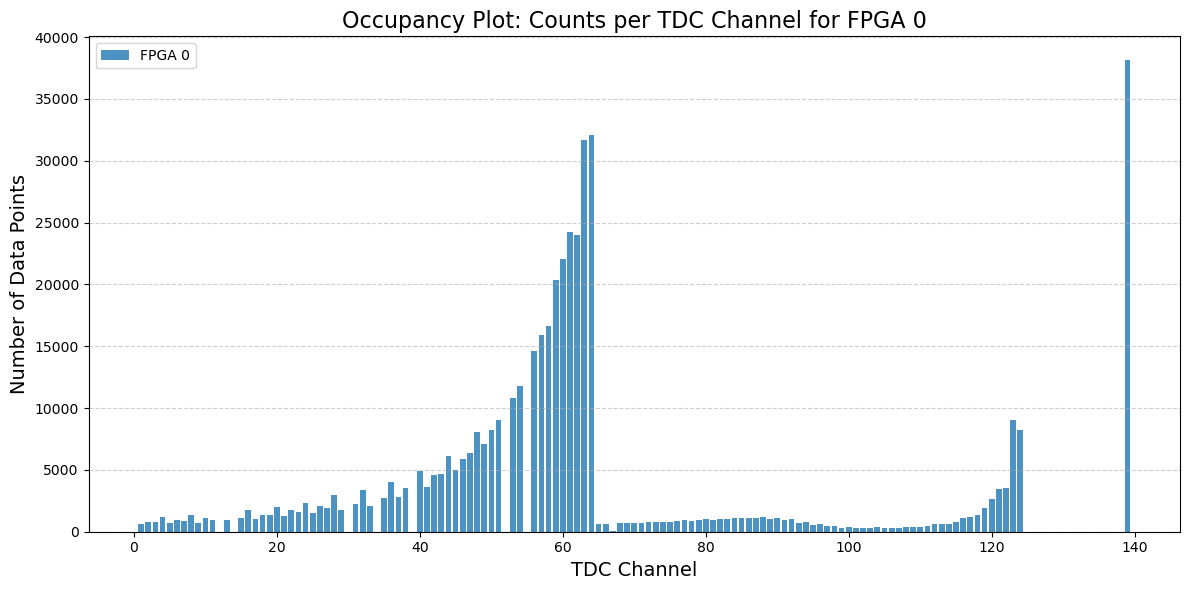

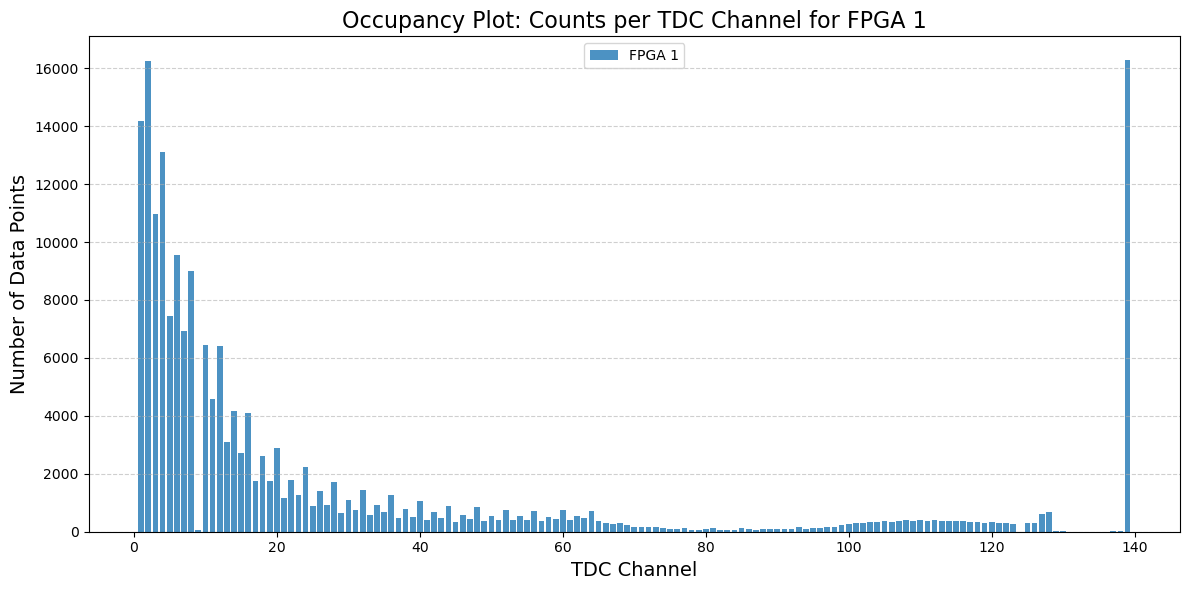

In [107]:
#Let's first have a quick idea of how groupby works
#channels = df.groupby('TDC_CHANNEL')
#for channel_idx, channel in channels: 
#    print(f"Channel:{channel_idx}")
#    print(channel)

grouped = df.groupby(['FPGA', 'TDC_CHANNEL']).size()
print(grouped)
print()

grouped = grouped.reset_index(name='Counts') #I make a new column with the size values
print(grouped)

# Separate data for each FPGA
for fpga_id in grouped['FPGA'].unique(): #Filters the data for each unique FPGA value.
    fpga_data = grouped[grouped['FPGA'] == fpga_id]
    
    # Plot for the current FPGA
    plt.figure(figsize=(12, 6))
    plt.bar(fpga_data['TDC_CHANNEL'], fpga_data['Counts'], alpha=0.8, label=f'FPGA {fpga_id}') #Creates a separate bar chart for each FPGA.
    plt.title(f'Occupancy Plot: Counts per TDC Channel for FPGA {fpga_id}', fontsize=16)
    plt.xlabel('TDC Channel', fontsize=14)
    plt.ylabel('Number of Data Points', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [118]:
# I have already grouped by FPGA and CHANNEL... now I can sort them and take the head of it. 
top_noisy_channels = dict(grouped['Counts'].sort_values(ascending=False).head(3))
print(f"Top noisy channels are:{tuple(top_noisy_channels.keys())} with counts: {tuple(top_noisy_channels.values())}")

Top noisy channels are:(123, 58, 57) with counts: (38149, 32098, 31706)



9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [129]:
# Let's first count the number of unique orbits

number_orbits = len(df['ORBIT_CNT'].unique())
print(f"There are {number_orbits} different orbits")

# Let's now count the mumber of orbits with at least one measurement from TDC_CHANNEL = 139
ok_orbits = 0
for idx, orbit in df.groupby('ORBIT_CNT'):
    for channel in orbit['TDC_CHANNEL'].unique(): 
        if channel == 139: 
            ok_orbits+=1

print(f"There are {ok_orbits} of different orbits that contain at least one measurement from TDC_CHANNEL = 139")

There are 6499 different orbits
There are 6474 of different orbits that contain at least one measurement from TDC_CHANNEL = 139


In [ ]:
# I could also use 
#for idx, orbit in df.groupby('ORBIT_CNT'):
 #   if 139 in orbit['TDC_CHANNEL'].unique():  # Check directly if 139 exists in unique values
  #      ok_orbits += 1
